# 9.1 Getting higher timeframe bars
I am interested in the 5-minute and 1-day timeframes.

In [1]:
from utils import remove_extended_hours
from datetime import datetime
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
DATA_PATH = "../data/polygon/"

In [2]:
all_files = os.listdir(DATA_PATH + f'processed/m1/')
for index, file in enumerate(all_files):
    ticker = file[:-19] # Remove date and parquet extension

    bars = pd.read_parquet(DATA_PATH + f'processed/m1/{file}')

    # In the backtester we will use the opening price of the next bar to trade. So 'tradeable' has to be based on the first 1-minute bar within each 5-minute interval for 5-minute bars. However your approach might be different. If you use closing prices, you should use the last 1-minute bar.
    m5 = bars.resample('5Min').agg({'open': 'first', 
                                    'high': 'max', 
                                    'low': 'min',
                                    'close': 'last',
                                    'close_original': 'last',
                                    'volume': 'sum',
                                    'tradeable': 'first',
                                    'halted': 'first'})
    # Pandas aggregation also adds non-trading days and times back. These can be easily removed by removing the NA values, because the first/max/min/last of nothing is NA. Also booleans are converted into 0/1, which has to be converted back.
    m5 = m5.dropna()
    m5['tradeable'] = m5['tradeable'].astype('bool')
    m5['halted'] = m5['halted'].astype('bool')      
    m5.to_parquet(DATA_PATH + f"processed/m5/{file}", engine="fastparquet", row_group_offsets=25000)
 
    # For the daily, we only consider a bar untradeable if it has zero trade prices. So if all "tradeable" is False. Also we only consider regular trading hours.
    bars = remove_extended_hours(bars)
    d1 = bars.resample('D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min',
                                 'close': 'last',
                                 'close_original': 'last',
                                 'volume': 'sum',
                                 'tradeable': 'max',
                                 'halted': 'min'})
    d1 = d1.dropna()
    d1['tradeable'] = d1['tradeable'].astype('bool')
    d1['halted'] = d1['halted'].astype('bool')   
    d1.to_parquet(DATA_PATH + f"processed/d1/{file}", engine="fastparquet", row_group_offsets=25000)

The daily bars look good:

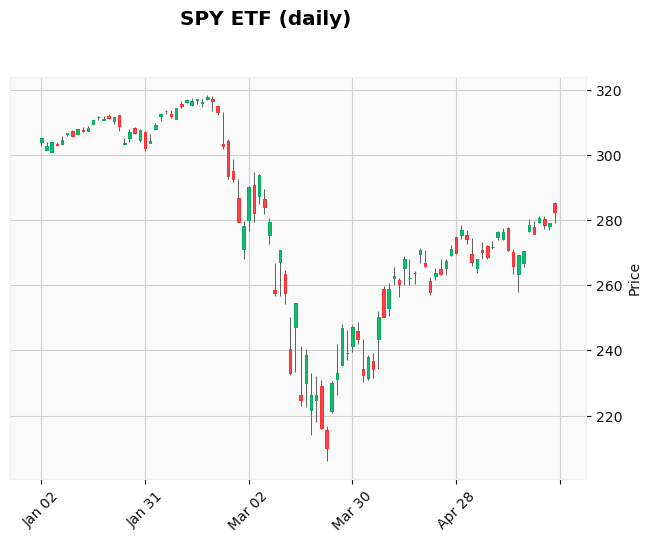

In [5]:
bars = pd.read_parquet(DATA_PATH + f"processed/d1/SPY-2019-06-01.parquet")
bars = bars[bars.index > datetime(2020, 1, 1)]
mpf.plot(bars.head(100), type='candle', style='yahoo', title='SPY ETF (daily)')

The 5-minute bars:

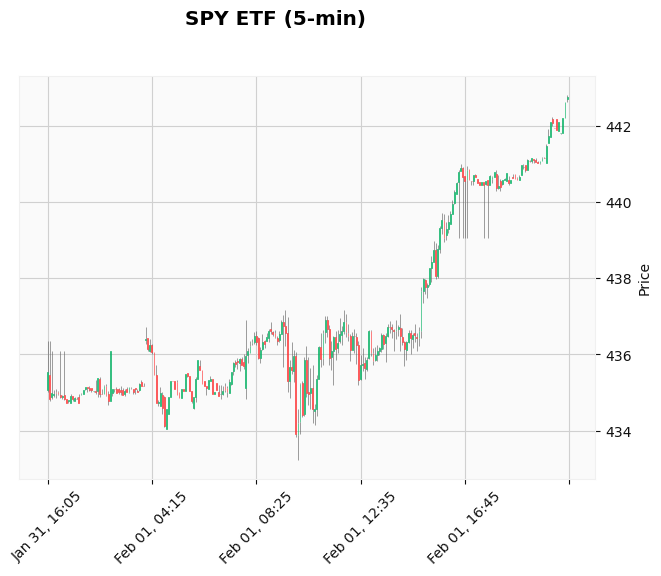

In [6]:
bars = pd.read_parquet(DATA_PATH + f"processed/m5/SPY-2019-06-01.parquet")
bars = bars[bars.index > datetime(2022, 1, 31, hour=16)]
mpf.plot(bars.head(250), type='candle', style='yahoo', title='SPY ETF (5-min)', show_nontrading=False)

As you can see there are a lot of stupid spikes in the data. These are because of late reported trades and make the data almost useless if uncleaned. However cleaning them is very cumbersome because you need to recreate the bars from tick data.

I actually e-mailed Polygon.io about this issue. They said they would propose to remove the late trades.

# 9.2 Updates
Rerun after updating END_DATE.